# Отток клиентов

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Подготовка-данных">Подготовка данных</a></li>
      <ul>
        <li><a href="#Формирование-выборок">Формирование выборок</a></li>
      </ul>      
    <li><a href="#Исследование-задачи">Исследование задачи</a></li>
       <ul>
        <li><a href="#Изучим-модели-без-учета-дисбаланса">Изучим модели без учета дисбаланса</a></li>
      </ul>    
    <li><a href="#Борьба-с-дисбалансом">Борьба с дисбалансом</a></li>
    <li><a href="#Исследование-метрики-AUC-ROC">Исследование метрики AUC-ROC</a></li>
    <li><a href="#Тестирование-модели">Тестирование модели</a></li>
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Построить модель, способную спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Задачи**:
    
    1. Загрузить и подготовить данные.        
    2. Исследовать баланс классов, обучить модель без учёта дисбаланса.       
    3. Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найдите лучшую.
    4. Провести финальное тестирование.    
    5. Сделать выводы по итогам работы.
    
---
    
### Описание данных

#### Признаки

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
#### Целевой признак
- `Exited` — факт ухода клиента

---

## Подготовка данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/datasets/Churn.csv")

In [3]:
#Выводим все, знакомимся с данными
data.info()
display(data.head())
print('\nЧисло дубликатов:', data.duplicated().sum())
print('Пропуски:\n', data.isnull().sum())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Число дубликатов: 0
Пропуски:
 RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
display(data['Geography'].unique())

array(['France', 'Spain', 'Germany'], dtype=object)

* `RowNumber` — Cтолбец дублирует информацию базы данных и не несет никакой пользы в обучении модели. Удаляю столбец
* `CustomerId` — Уникальный идентификатор клиента, так же не несет никакой пользы в обучении модели. Дубликатов нет, удаляю столбец
* `Surname` — Фамилия не несет ценности для обучения модели. Удаляю столбец
* `CreditScore` — Кредитный рейтинг. Пригодится для исследования
* `Geography` — Cтрана проживания. Всего 3 уникальных значения, выполню преобразование OHE 
* `Gender` — Пол. Выполню преобразование OHE 
* `Age` — Возраст. Пригодится для исследования
* `Tenure` — Сколько лет человек является клиентом банка. Пригодится для исследования, изменю тип данных на int, заполню пропуски медианным по датафрейму значением 5 лет.
* `Balance` — Баланс на счёте. Пригодится для исследования.
* `NumOfProducts` — Количество продуктов банка, используемых клиентом. Пригодится для исследования.
* `HasCrCard` — Наличие кредитной карты. Пригодится для исследования.
* `IsActiveMember` — Активность клиента. Пригодится для исследования.
* `EstimatedSalary` — Предполагаемая зарплата. Пригодится для исследования.
* `Exited` — Факт ухода клиента. Пригодится для исследования.

In [5]:
data_del = ["RowNumber", 'CustomerId', 'Surname']# Столбцы на удаление
df_ml = data.drop(data_del, axis=1) #Данные для обучения модели

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

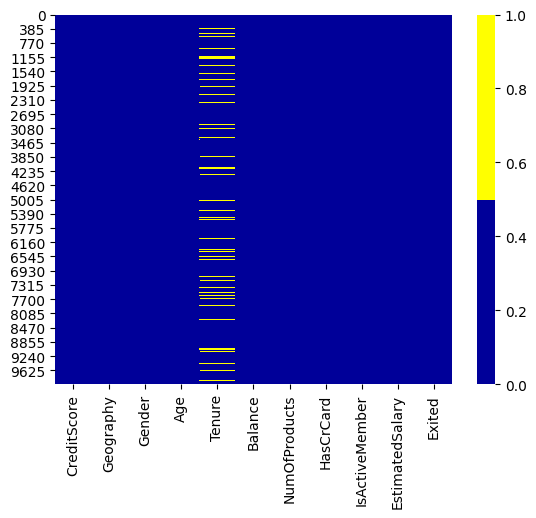

In [6]:
#Смотрю пропуски
display(df_ml['Tenure'].unique())
cols = df_ml.columns[:]
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_ml[cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

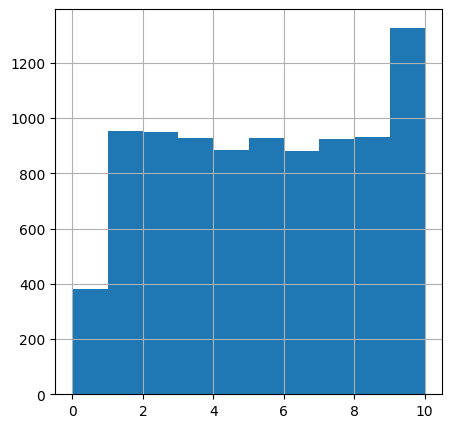

In [7]:
df_ml["Tenure"].hist(figsize=(5, 5));

In [8]:
#Убираю пропуски и меняю тип данных
df_ml['Tenure'] = df_ml['Tenure'].fillna(pd.Series(np.random.randint(1, 11, size=len(df_ml['Tenure'].isna()))))
df_ml['Tenure'] = df_ml['Tenure'].astype(int)

Пропуски:
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


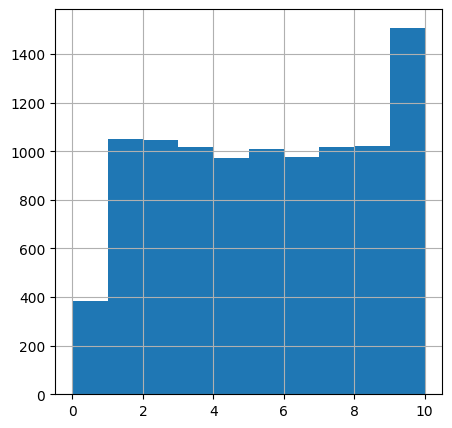

In [9]:
print('Пропуски:\n', df_ml.isnull().sum())
df_ml["Tenure"].hist(figsize=(5, 5));

In [10]:
# Оцениваю обработанные данные
df_ml.info()
display(df_ml.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int32  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


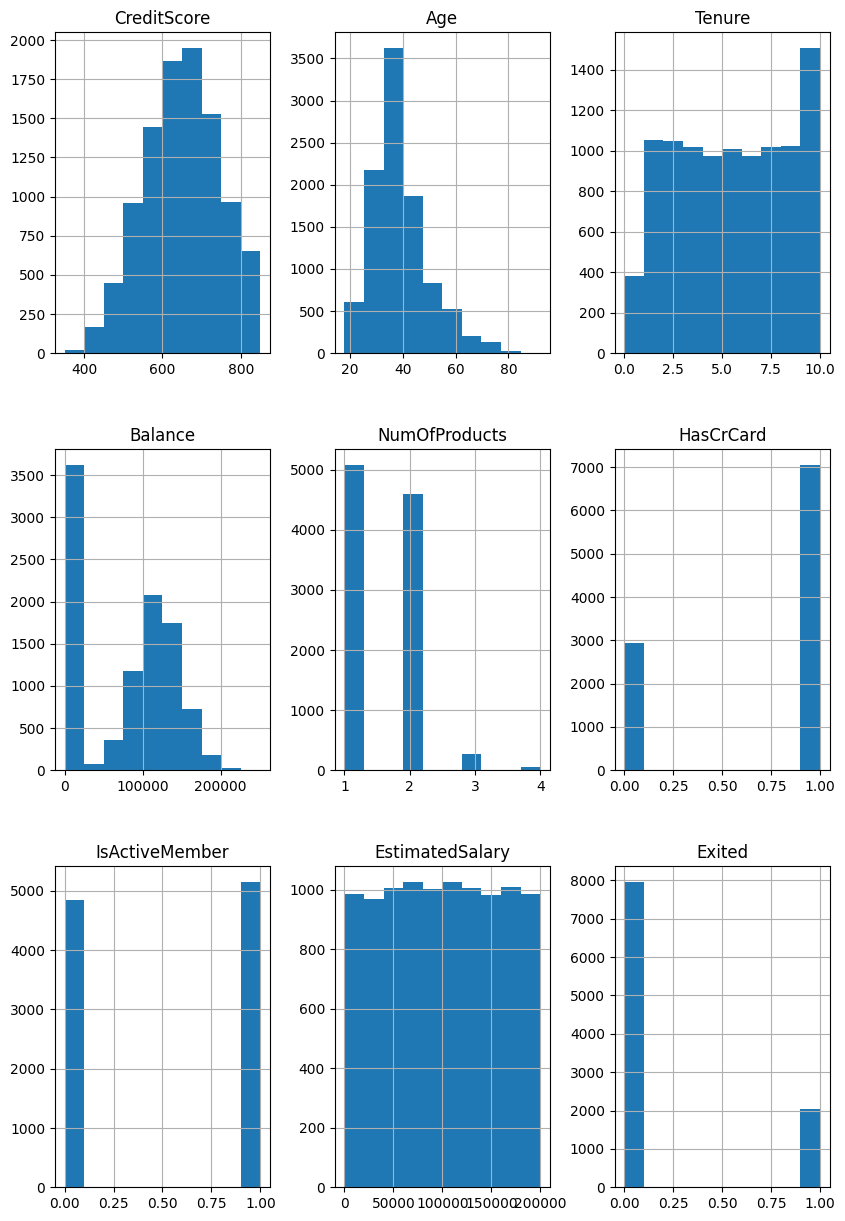

In [11]:
df_ml.hist(figsize=(10, 15));

In [12]:
df_ml.corr(method='spearman')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.007974,0.003100,0.005687,0.012568,-0.003802,0.024262,0.001237,-0.023289
Age,-0.007974,1.000000,-0.010294,0.033304,-0.058566,-0.015278,0.039839,-0.002431,0.323968
Tenure,0.003100,-0.010294,1.000000,-0.004141,0.008942,0.025740,-0.029378,0.007291,-0.010079
Balance,0.005687,0.033304,-0.004141,1.000000,-0.316627,-0.009835,-0.011497,0.011778,0.111110
NumOfProducts,0.012568,-0.058566,0.008942,-0.316627,1.000000,0.003859,0.016292,0.012570,-0.125282
HasCrCard,-0.003802,-0.015278,0.025740,-0.009835,0.003859,1.000000,-0.011866,-0.010041,-0.007138
IsActiveMember,0.024262,0.039839,-0.029378,-0.011497,0.016292,-0.011866,1.000000,-0.011469,-0.156128
EstimatedSalary,0.001237,-0.002431,0.007291,0.011778,0.012570,-0.010041,-0.011469,1.000000,0.012081
Exited,-0.023289,0.323968,-0.010079,0.111110,-0.125282,-0.007138,-0.156128,0.012081,1.000000


Заметной корреляции нет

### Формирование выборок

Данные разобьем на три части: обучающую, валидационную и тестовую. Исходные данные разобью в соотношении 60%, 20%, 20%.

In [13]:
features = df_ml.drop("Exited", axis=1) # признаки 
target = df_ml["Exited"] # целевой признак

#### Обучающая выборка

In [14]:
# Обучающая и (валидационная + тестовая)
features_train, features_valid, target_train, target_valid = train_test_split(
                                                                              features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=54321
                                                                             ) 
print(features_train.shape)
print(target_train.shape)

(6000, 10)
(6000,)


In [15]:
# Валидациоонная и тестовая
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5, 
                                                                            random_state=54321
                                                                           ) 

#### Валидациоонная выборка

In [16]:
print(features_valid.shape)
print(target_valid.shape)

(2000, 10)
(2000,)


#### Тестовая выборка

In [17]:
print(features_test.shape)
print(target_test.shape)

(2000, 10)
(2000,)


In [18]:
# кодирование ohe
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

#Для масштабирования методом scaler зафиксируем численные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] 
scaler = StandardScaler()
scaler.fit(features_train[numeric])

#Масштабируем численные признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])
#Валидационной выборки 
features_valid[numeric] = scaler.transform(features_valid[numeric])
#Тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])

In [19]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5241,-0.780083,0.197157,-1.386043,-1.229774,0.813812,0,0,-0.527135,0,0,1
5716,-0.400308,-0.180991,-1.386043,0.651137,0.813812,0,1,1.051744,1,0,1
8581,-0.667177,0.386232,-1.041299,-1.229774,0.813812,1,0,-0.198282,0,0,0
3808,0.523471,0.197157,-1.730787,1.184406,-0.917089,0,1,0.468420,1,0,1
8541,-0.030796,0.764380,-0.007067,0.460340,0.813812,1,1,0.987144,0,1,1


### Вывод

* Предварительно оценил данные.
* Обработал данные: Заполнил пропуски и изменил тип данных, удалил не влияющие на исследование столбцы, применил прямое кодирование OHE.
* Разбил данные на обучающую, валидационную и тестовую выборку.
* Стандартизировал маштабирование признаков для трех выборок.

## Исследование задачи

Проверим выборку на дисбаланс классов

0    0.798
1    0.202
Name: Exited, dtype: float64

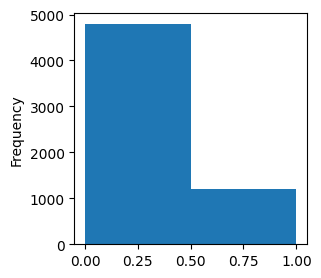

In [20]:
# Смотрим дисбаланс классов
target_train.plot(kind ='hist', bins=2, figsize=(3,3))
target_train.value_counts(normalize = True)

В нашей выборке отрицательных ответов  ≈ 80% , положитительных ≈ 20%. С уверенностью можем сказать, что имеется дисбаланс. 

### Изучим модели без учета дисбаланса

In [21]:
# функция для изучения точности, полноты и F1-меры
def rec_prec_f1(target_valid, prediction):
    print("Точность", precision_score(target_valid, prediction))
    print("Полнота" , recall_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [22]:
# функция для изучения метрики AUC_ROC
def auc_roc_digit (model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    return auc_roc

Исследуем модели классификации до учета дисбаланса, оценим качество моделей по F1-мере и AUC-ROC.

In [23]:
# DecisionTreeClassifier
best_model_dtc = None
best_result_dtc = 0
best_max_depth_dtc = 0

for depth in range(1, 101):
    model_dtc = DecisionTreeClassifier(random_state=54321, max_depth=depth).fit(features_train, target_train) 
    predictions_valid_dtc = model_dtc.predict(features_valid) # предсказания модели
    result_dtc = f1_score(target_valid, predictions_valid_dtc) # качество модели
    if result_dtc > best_result_dtc:
        best_model_dtc = model_dtc
        best_result_dtc = result_dtc
        best_max_depth_dtc = depth

print('best max_depth =', best_max_depth_dtc)
rec_prec_f1(target_valid, predictions_valid_dtc)

best max_depth = 7
Точность 0.4681818181818182
Полнота 0.515
F1-мера 0.49047619047619057


In [24]:
#смотрим матрицу ошибок
confusion_matrix(target_valid, predictions_valid_dtc)

array([[1366,  234],
       [ 194,  206]], dtype=int64)

##### Вывод
Решающее дерево часто выдает неверные предсказания (FN) и (FP). Низкое значение F1-меры, соответсвенно низкое качество модели, проблема в точности и полноте.

In [25]:
# RandomForestClassifier

best_model_rfc = None
best_est_rfc = 0
best_result_rfc = 0
best_depth_rfc = 0


for depth in tqdm(range(1, 21)):
    for est in range(1, 51):
        model_rfc = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth).fit(features_train, target_train)
        predictions_valid_rfc = model_rfc.predict(features_valid)
        result_rfc = f1_score(predictions_valid_rfc, target_valid)
        if best_result_rfc < result_rfc:
            best_model_rfc = model_rfc
            best_est_rfc = est
            best_result_rfc = result_rfc
            best_depth_rfc = depth
            
print('best est =', best_est_rfc)
print('best max_depth =', best_depth_rfc) 
rec_prec_f1(target_valid, predictions_valid_rfc)

100%|██████████| 20/20 [04:48<00:00, 14.45s/it]

best est = 41
best max_depth = 18
Точность 0.7531914893617021
Полнота 0.4425
F1-мера 0.5574803149606299


In [26]:
confusion_matrix(target_valid, predictions_valid_rfc)

array([[1542,   58],
       [ 223,  177]], dtype=int64)

##### Вывод
Случайный лес часто выдает ложно отрицательные предсказания (FN). Низкое значение F1-меры, соответсвенно низкое качество модели, проблема в полноте. Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке

In [27]:
# Logistic Regression
model_lr = LogisticRegression (random_state=54321).fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
best_result_lr = f1_score(predictions_valid_lr, target_valid)

rec_prec_f1(target_valid, predictions_valid_lr)

Точность 0.7064220183486238
Полнота 0.1925
F1-мера 0.30255402750491156


In [28]:
confusion_matrix(target_valid, predictions_valid_lr)

array([[1568,   32],
       [ 323,   77]], dtype=int64)

##### Вывод
Логичстическая регрессия часто выдает ложно отрицательные предсказания (FN). Низкое значение F1-меры, соответсвенно низкое качество модели, проблема в полноте.

### Общий вывод по моделям без учета дисбаланса
Рассматривая данные с дисбалансом по трем моделями можно сделать вывод, что самая лучшая модель оказалась Случайный лес. При лучшем значении гиперпараметров est = 28, max_depth = 15, мы имеем F1 меру =0.570 на валидационной выборке.

## Борьба с дисбалансом

Раннее мы выяснили, что в нашей выборке положительных ответов 20%, а отрицательных 80%, cоотношение 1:4. Значит нужно увеличить количество положительных ответов в 4 раза или уменьшить количество отрицательных в 4 раза.

In [29]:
##Функция для увеличения класса в выборке 
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    #Увеличиваем и соединяем обратно
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Перемешиваем
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)
    
    return features_upsampled, target_upsampled

1    0.503113
0    0.496887
Name: Exited, dtype: float64


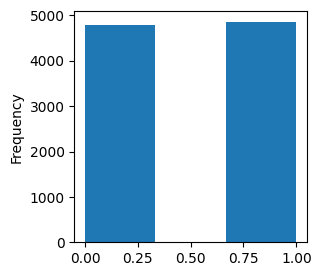

In [30]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
target_train_upsampled.plot(kind ='hist', bins=3, figsize=(3,3))
print(target_train_upsampled.value_counts(normalize = 1))

Хотя функция уже балансирует выборку, чек-лист просит применить несколько способов борьбы с дисбалансом. Рассмотрим функцию уменьшение выборки.

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)
    
    return features_downsampled, target_downsampled

1    0.503113
0    0.496887
Name: Exited, dtype: float64


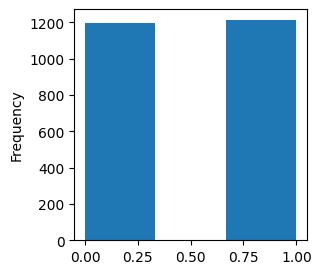

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
target_downsampled.plot(kind ='hist', bins=3, figsize=(3,3))
print(target_train_upsampled.value_counts(normalize = 1))

Выборка сбалансирована, обучим модели.

In [34]:
best_model_dtc_new = None
best_result_dtc_new = 0
best_max_depth_dtc_new = 0

for depth in range(1, 101):
    model_dtc_new = DecisionTreeClassifier(random_state=54321, max_depth=depth).fit(features_train_upsampled, target_train_upsampled) 
    predictions_valid_dtc_new = model_dtc_new.predict(features_valid) # предсказания модели
    result_dtc = f1_score(target_valid, predictions_valid_dtc_new) # качество модели
    if result_dtc > best_result_dtc_new:
        best_model_dtc_new = model_dtc
        best_result_dtc_new = result_dtc
        best_max_depth_dtc_new = depth


print("Старые значения Решающего дерева:\n"
    "best max_depth = 7\n"
    "Точность 0.4681818181818182\n"
    "Полнота 0.515\n"
    "F1-мера 0.49047619047619057") 
print("\nНовые значения Решающего дерева:") 
print('best max_depth =', best_max_depth_dtc)
rec_prec_f1(target_valid, predictions_valid_dtc_new)

Старые значения Решающего дерева:
best max_depth = 7
Точность 0.4681818181818182
Полнота 0.515
F1-мера 0.49047619047619057

Новые значения Решающего дерева:
best max_depth = 7
Точность 0.4713216957605985
Полнота 0.4725
F1-мера 0.47191011235955055


##### Вывод
Модель решающее дерево качественно упала по всем показателям.

In [35]:
best_model_rfc_new = None
best_est_rfc_new = 0
best_result_rfc_new = 0
best_depth_rfc_new = 0


for depth in tqdm(range(1, 21)):
    for est in range(1, 51):
        model_rfc_new = RandomForestClassifier(random_state=54321, n_estimators=est, max_depth = depth).fit(features_train_upsampled, target_train_upsampled)
        predictions_valid_rfc_new = model_rfc_new.predict(features_valid)
        result_rfc = f1_score(predictions_valid_rfc_new, target_valid)
        if best_result_rfc < result_rfc:
            best_model_rfc_new = model_rfc
            best_est_rfc_new = est
            best_result_rfc_new = result_rfc
            best_depth_rfc_new = depth
 

print("Старые значения Случайного леса:\n"
    "best est = 41\n"
    "best max_depth = 18\n"
    "Точность 0.7531914893617021\n"
    "Полнота 0.4425\n"
    "F1-мера 0.5574803149606299") 
print("\nНовые значения Случайного леса:") 
print('best est =', best_est_rfc_new)
print('best max_depth =', best_depth_rfc_new) 
rec_prec_f1(target_valid, predictions_valid_rfc_new)

100%|██████████| 20/20 [06:27<00:00, 19.39s/it]

Старые значения Случайного леса:
best est = 41
best max_depth = 18
Точность 0.7531914893617021
Полнота 0.4425
F1-мера 0.5574803149606299

Новые значения Случайного леса:
best est = 50
best max_depth = 20
Точность 0.6787878787878788
Полнота 0.56
F1-мера 0.6136986301369864


##### Вывод
Модель случайный лес качественно выросла и уже показывает резульаты F1 меры = 0.613, что выше нашего целевого целевого значения (0.59).

In [36]:
model_lr_new = LogisticRegression (random_state=54321).fit(features_train_upsampled, target_train_upsampled)
predictions_valid_lr_new = model_lr_new.predict(features_valid)
best_result_lr = f1_score(predictions_valid_lr_new, target_valid)

print("Старые значения Логистической регрессии:\n"
    "Точность 0.7064220183486238\n"
    "Полнота 0.1925\n"
    "F1-мера 0.30255402750491156") 
print("\nНовые значения Случайного леса:") 
rec_prec_f1(target_valid, predictions_valid_lr_new)

Старые значения Логистической регрессии:
Точность 0.7064220183486238
Полнота 0.1925
F1-мера 0.30255402750491156

Новые значения Случайного леса:
Точность 0.39357429718875503
Полнота 0.735
F1-мера 0.5126416739319966


##### Вывод
Модель логистическая регрессия качественно выросла, но недостаточно для целевого показателя.

### Общий вывод по моделям с учетом дисбаланса
* Показатели всех моделей улучшились, кроме Решающего дерева. 
* Лучшие результаты показывает модель случайный лес (RandomForestClassifier). На валидационной выборке показывает резульаты F1 меры = 0.613, что выше целевого целевого значения.

## Исследование метрики AUC-ROC

Сравним AUC-ROC метрики разных моделей

In [37]:
# функция для графика по auc-roc
def auc_roc_plot (model):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds=roc_curve(target_valid, probabilities_one_valid)
    return fpr, tpr

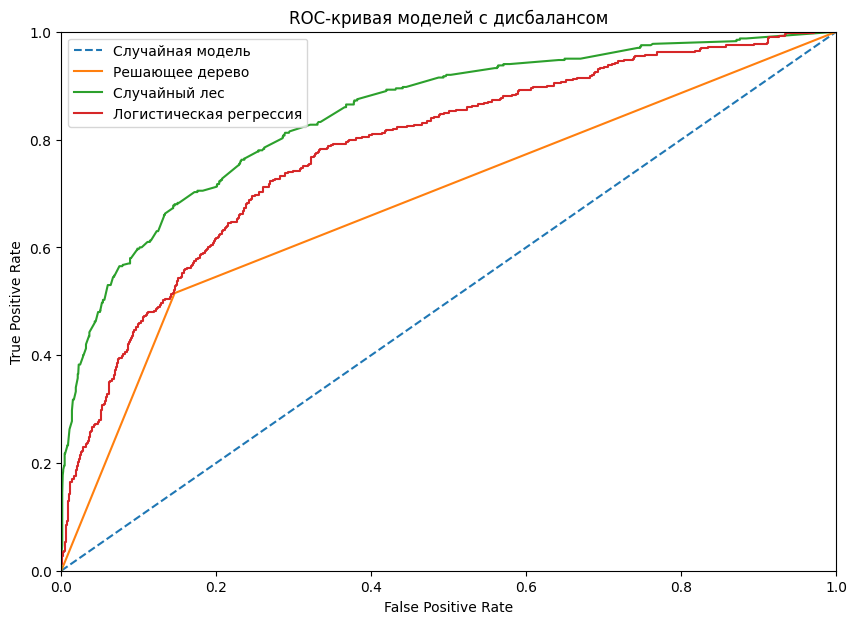

Метрика ROC-кривая: для Решающего дерева = 0.6843750000000001
Метрика ROC-кривая: для Случайного леса = 0.8472828124999999
Метрика ROC-кривая: для Логистической регрессии = 0.7814828125


In [38]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
list1, list2 = auc_roc_plot(model_dtc)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(model_rfc)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(model_lr)
plt.plot(list1, list2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая моделей с дисбалансом')
plt.legend(('Случайная модель','Решающее дерево','Случайный лес','Логистическая регрессия'),
           loc= 'upper left') 
plt.show()

print("Метрика ROC-кривая: для Решающего дерева =", auc_roc_digit (model_dtc))
print("Метрика ROC-кривая: для Случайного леса =", auc_roc_digit (model_rfc))
print("Метрика ROC-кривая: для Логистической регрессии =", auc_roc_digit (model_lr))

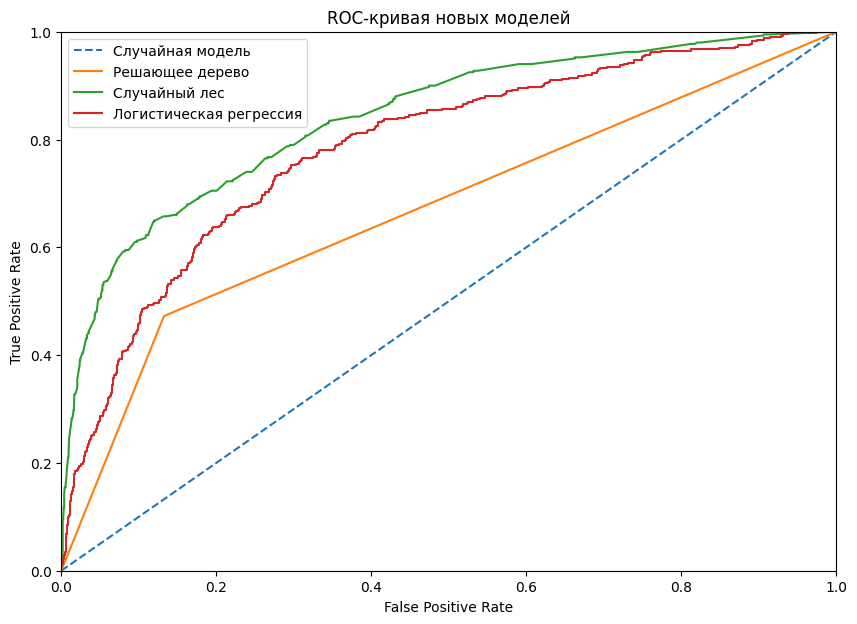

Метрика ROC-кривая: для Решающего дерева = 0.6699999999999999
Метрика ROC-кривая: для Случайного леса = 0.8412835937500002
Метрика ROC-кривая: для Логистической регрессии = 0.7854484374999999


In [39]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
list1, list2 = auc_roc_plot(model_dtc_new)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(model_rfc_new)
plt.plot(list1, list2)
list1, list2 = auc_roc_plot(model_lr_new)
plt.plot(list1, list2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая новых моделей')
plt.legend(('Случайная модель','Решающее дерево','Случайный лес','Логистическая регрессия'),
           loc= 'upper left') 
plt.show()

print("Метрика ROC-кривая: для Решающего дерева =", auc_roc_digit (model_dtc_new))
print("Метрика ROC-кривая: для Случайного леса =", auc_roc_digit (model_rfc_new))
print("Метрика ROC-кривая: для Логистической регрессии =", auc_roc_digit (model_lr_new))

### Вывод 
* Лучший результат AUC_ROC метрики показывает модель случайного лес (RandomForestClassifier). 
* Дисбаланс в выборке незначительно повлиял на метрику AUC_ROC.

## Тестирование модели

Проведем тест модели показавший лучший результат - Случайный лес (RandomForestClassifier)

In [40]:
#Обучим финальную модель
model_final = RandomForestClassifier(
    class_weight = 'balanced', max_depth= 20,  n_estimators = 50, random_state=35434
    ).fit(features_train_upsampled, target_train_upsampled)
model_final_prediction = model_final.predict(features_test)

rec_prec_f1(target_test, model_final_prediction)

Точность 0.6513513513513514
Полнота 0.5670588235294117
F1-мера 0.6062893081761006


Целевой показатель (F1-мера выше 0.59) получен.

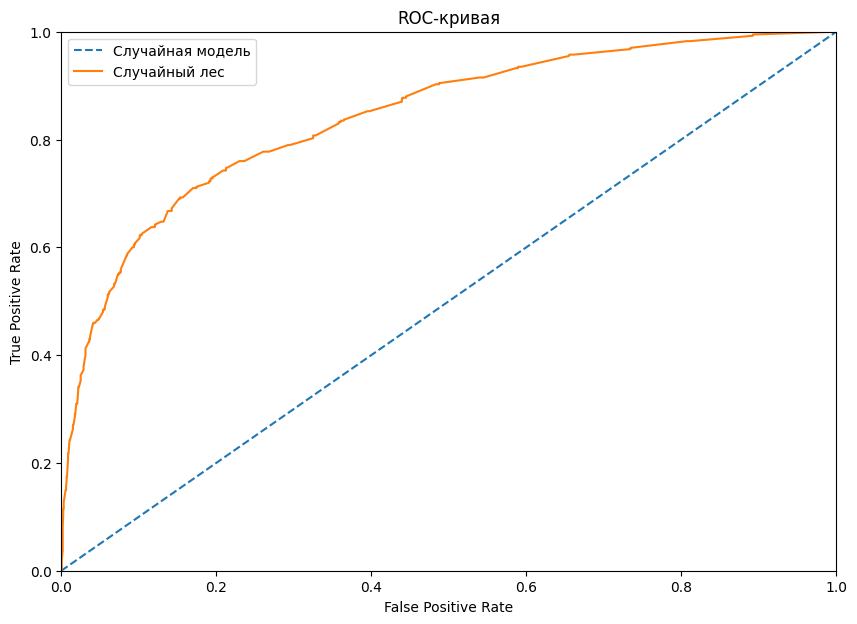

Метрика ROC-кривая: для Случайного леса = 0.8420679687500001


In [41]:
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
list1, list2 = auc_roc_plot(model_final)
plt.plot(list1, list2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес'),
           loc= 'upper left') 
plt.show()
print("Метрика ROC-кривая: для Случайного леса =", auc_roc_digit (model_final))

Значение площади над константной прямой, модель адекватна.

## Общий вывод

* Изучил и подготовил данные к исследованию.
* Изучил влияние дисбаланса классов на модели классификации применяя метрики, такие как *F1-мера* и *AUC_ROC*.
* Применил методы для преобразования дисбаланса классов, такие как *upsample* и *downsample*.
* Провел тестирование моделей, в ходе которой лучший результат показала модель  *RandomForestClassifier*: 
    
    Точность = 0.6513513513513514,
    Полнота = 0.5670588235294117, 
    F1-мера = 0.6062893081761006, 
    AUC_ROC = 0.8420679687500001.   